In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.2 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# from src.running import train_step1, eval_step1

<ipython-input-4-a8a3463e6cef>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [57]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 64,
    'neighs': 10,
    'neigh_weigh': 'uniform',
    'dist_metric': 'l2',
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_I3D_pkl(loc, action_list, feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  i3ds = {}
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    i3ds[action_list.index(k)] = np.asarray(all_arr)
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "prototype":prototype, 'features': i3ds}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path, actionList, feat_size="400")
video_classes, video_feat, feat_dict = video_data['activity'], video_data['prototype'], video_data['features']

In [11]:
# re-arrange semantic space
activity_dict = dict(zip(video_classes, video_feat))
semantic_space = np.array([activity_dict[c] for c in actionList])

In [12]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [13]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [14]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [16]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [17]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [18]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [19]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [20]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [21]:
def gen_semantic_space(ft_dict, seen_classes):
    action_ft = np.concatenate(list(ft_dict.values()), axis=0)

    class_dict = {c: i for i,c in enumerate(seen_classes)}
    n_cls = len(seen_classes)
    action_label = []
    for k in list(ft_dict.keys()):
        d = k # class_dict[k]
        for _ in range(ft_dict[k].shape[0]):
            action_label.append(d)

    action_label = np.array(action_label)
    return action_ft, action_label

In [50]:
def unseen_eval_step(model, dataloader, sem_actions, sem_labels, loss_module, device, class_names, class_ids, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7, neighs=5, n_weights='uniform'):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    

    ld = dict(zip(class_ids, range(len(class_ids))))
    all_actions = sem_actions
    all_labels = np.array([ld[e] for e in sem_labels])
    # build knn model on know unseen samples 
    clf = KNeighborsClassifier(n_neighbors=neighs, algorithm='auto', metric=config['dist_metric'], metric_params=None, n_jobs=None, weights=n_weights)
    # clf = KNeighborsClassifier(n_neighbors=neighs)
    clf.fit(sem_actions, all_labels)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)

            # convert feature vector into action class using cosine
            feat_numpy = feat_output.cpu().detach().numpy()
            pred_action = clf.predict(feat_numpy)
  
            with torch.no_grad():
                metrics['samples'] += len(targets)

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [23]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [24]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [62]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-175


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.270



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.430



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.477



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.570



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.757



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.793



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.873



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.971



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.979



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.978



unseen:   0%|          | 0/42 [00:00<?, ?batch/s]

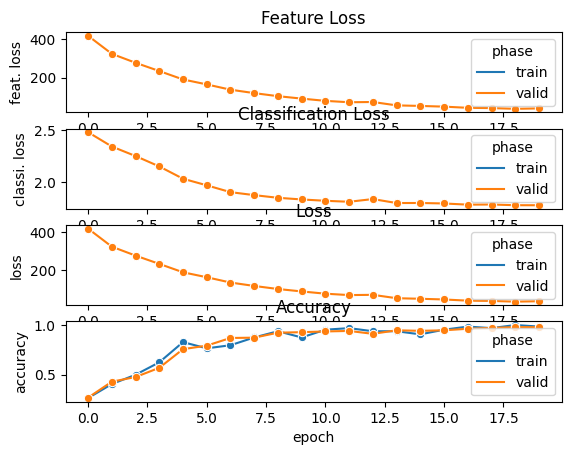

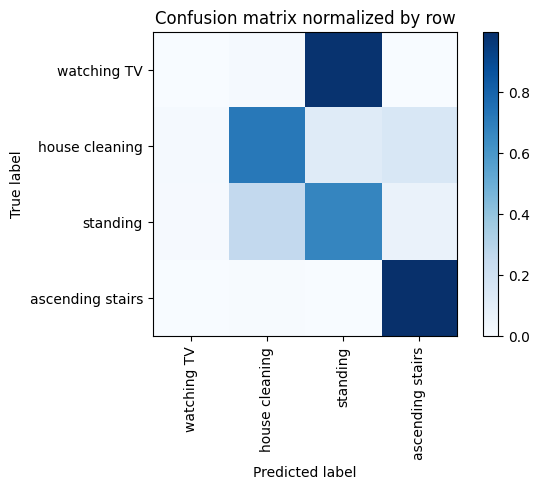

Overall accuracy: 0.641

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.729      0.717      0.723      0.336        904|	 ascending stairs: 0.154,	standing: 0.117,	
        standing       0.540      0.668      0.597      0.333        894|	 house cleaning: 0.261,	ascending stairs: 0.064,	
ascending stairs       0.708      0.996      0.828      0.179        480|	 house cleaning: 0.004,	standing: 0.000,	
     watching TV       0.000      0.000      0.000      0.153        410|	 standing: 0.983,	house cleaning: 0.015,	ascending stairs: 0.002,	

----------------------------------------------------------------------------------------------------
     avg / total       0.551      0.641      0.589        1.0       2688|	      

{'accuracy': 0.6409970238095238, 'precision': 0.49421000908641693, 'recall': 0.5951081818811743, 'f1': 0.5368791397763791, 'samples': 2688, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
=====

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.220



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.407



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.532



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.675



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.794



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.879



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.884



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.924



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.957



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.961



unseen:   0%|          | 0/41 [00:00<?, ?batch/s]

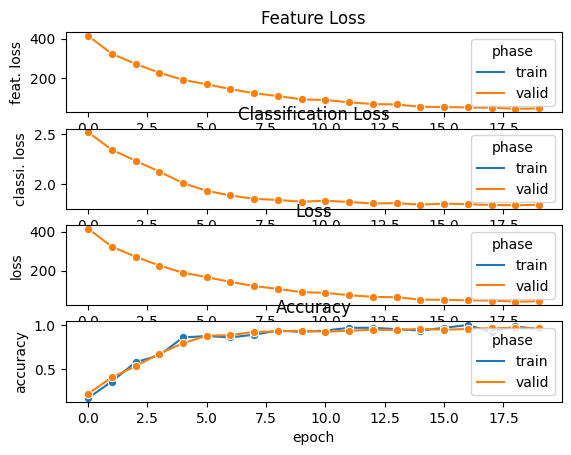

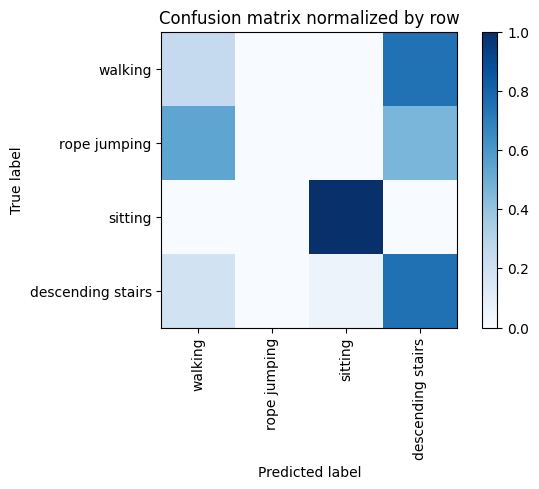

Overall accuracy: 0.558

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.599      0.251      0.354      0.432       1134|	 descending stairs: 0.748,	sitting: 0.001,	
          sitting       0.972      1.000      0.986      0.331        869|	 descending stairs: 0.000,	rope jumping: 0.000,	
descending stairs       0.246      0.752      0.371      0.157        411|	 walking: 0.190,	sitting: 0.058,	
     rope jumping       0.000      0.000      0.000      0.080        210|	 walking: 0.538,	descending stairs: 0.462,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.619      0.558      0.538        1.0       2624|	      

{'accuracy': 0.557545731707317, 'precision': 0.45429669330883826, 'recall': 0.5007868922102499, 'f1': 0.4277570159725083, 'samples': 2624, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
================

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.198



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.273



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.345



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.379



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.727



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.754



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.786



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.856



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.883



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.879



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.888



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.893



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.885



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.902



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.948



unseen:   0%|          | 0/54 [00:00<?, ?batch/s]

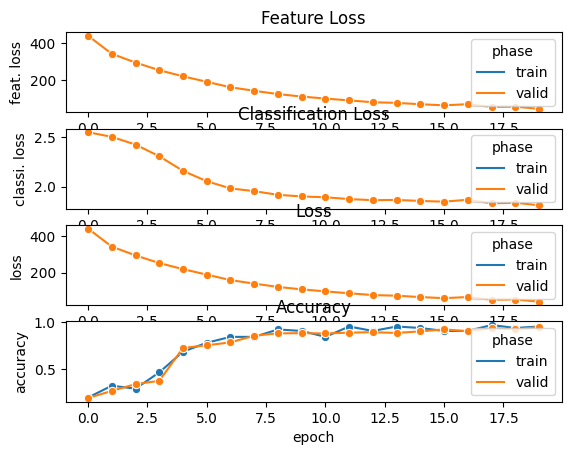

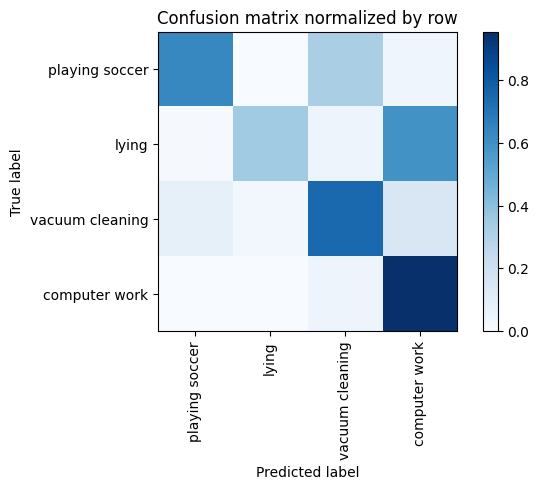

Overall accuracy: 0.727

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.685      0.954      0.798      0.438       1514|	 vacuum cleaning: 0.046,	lying: 0.000,	
          lying       0.935      0.348      0.507      0.261        902|	 computer work: 0.594,	vacuum cleaning: 0.048,	
vacuum cleaning       0.770      0.748      0.759      0.238        821|	 computer work: 0.145,	playing soccer: 0.080,	
 playing soccer       0.650      0.635      0.642      0.063        219|	 vacuum cleaning: 0.324,	computer work: 0.041,	

----------------------------------------------------------------------------------------------------
    avg / total       0.768      0.727      0.703        1.0       3456|	      

{'accuracy': 0.7268518518518519, 'precision': 0.7599010803631233, 'recall': 0.6712780780159754, 'f1': 0.6764863207680122, 'samples': 3456, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
================ Fold-3 ========

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.082



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.278



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.428



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.742



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.814



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.841



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.836



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.844



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.863



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.869



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.867



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.908



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.927



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.953



unseen:   0%|          | 0/33 [00:00<?, ?batch/s]

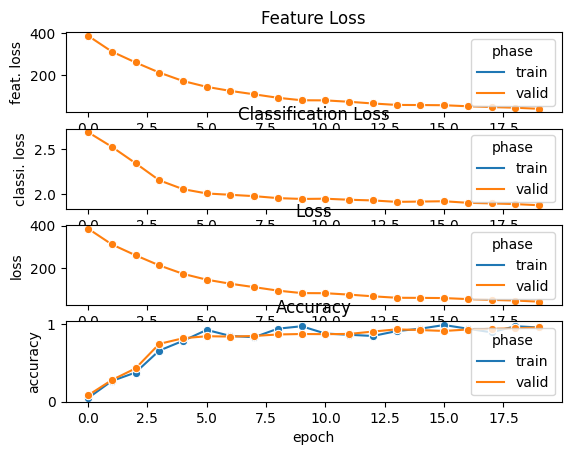

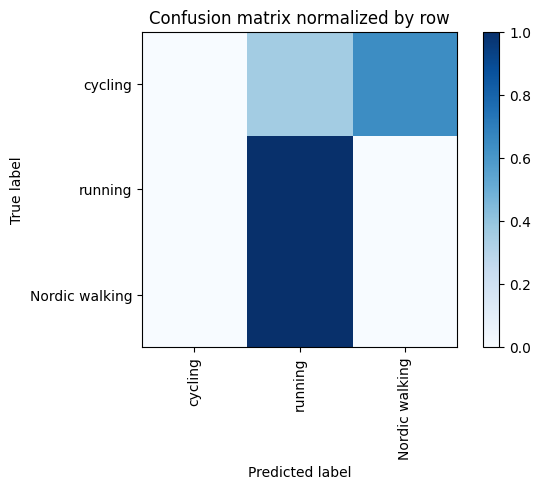

Overall accuracy: 0.214

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.420        888|	 running: 1.000,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.366        773|	 Nordic walking: 0.642,	running: 0.358,	
       running       0.279      1.000      0.436      0.214        451|	 Nordic walking: 0.000,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.060      0.214      0.093        1.0       2112|	      

{'accuracy': 0.21354166666666666, 'precision': 0.09302805280528054, 'recall': 0.3333333333333333, 'f1': 0.145460409611353, 'samples': 2112, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unse

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.109



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.236



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.476



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.663



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.753



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.827



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.834



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.847



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.842



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.846



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.926



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.935



unseen:   0%|          | 0/29 [00:00<?, ?batch/s]

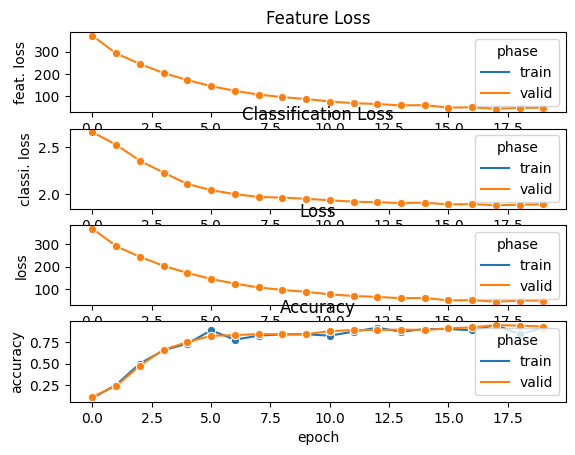

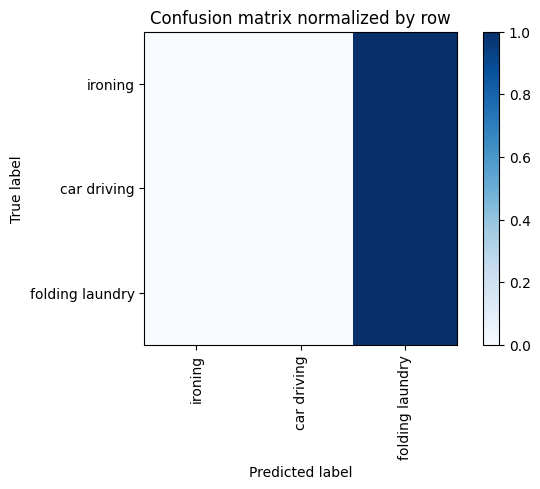

Overall accuracy: 0.252

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       1126|	 folding laundry: 0.996,	car driving: 0.004,	
folding laundry       0.253      1.000      0.403      0.252        468|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.141        262|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.252      0.102        1.0       1856|	      

{'accuracy': 0.2521551724137931, 'precision': 0.08423326133909287, 'recall': 0.3333333333333333, 'f1': 0.13448275862068965, 'samples': 1856, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.505482
precision    0.409190
recall       0.503816
f1           0.411351
dtype: 

In [63]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    seen_feat_dict = {a: f for a,f in feat_dict.items() if a in seen_classes}
    unseen_feat_dict = {a: f for a,f in feat_dict.items() if a in unseen_classes}
    seen_action_ft, seen_action_label = gen_semantic_space(seen_feat_dict, seen_classes)
    unseen_action_ft, unseen_action_label = gen_semantic_space(unseen_feat_dict, unseen_classes)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = unseen_eval_step(model, test_dl, unseen_action_ft, unseen_action_label, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes, phase='unseen', loss_alpha=config['imu_alpha'], print_report=True, show_plot=True, neighs=config['neighs'], n_weights=config['neigh_weigh'])
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
